In [1]:
#Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")


In [4]:
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")  # sometimes deliveries.csv or ball_by_ball.csv


In [5]:
matches.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [6]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [9]:
#Quick Inspect & Basic Cleaning

print(matches.shape, deliveries.shape)

(756, 18) (179078, 21)


In [10]:

print(matches.columns)


Index(['id', 'Season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')


In [11]:
print(deliveries.columns)

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')


In [12]:
# Standardize column names if needed
matches.columns = matches.columns.str.lower().str.strip()
deliveries.columns = deliveries.columns.str.lower().str.strip()

In [14]:
# Parse date and derive season (if not already present)
if "date" in matches.columns:
    matches["date"] = pd.to_datetime(matches["date"], errors="coerce")
if "season" not in matches.columns:
    matches["season"] = matches["date"].dt.year
    
# Basic NA fixes
for c in ["winner", "venue", "city"]:
    if c in matches.columns:
        matches[c] = matches[c].fillna("Unknown")

deliveries["batsman_runs"] = pd.to_numeric(deliveries.get("batsman_runs", 0), errors="coerce").fillna(0).astype(int)
deliveries["total_runs"]  = pd.to_numeric(deliveries.get("total_runs", 0), errors="coerce").fillna(0).astype(int)

matches[["season","team1","team2","winner","venue"]].head()


,season,team1,team2,winner,venue
0,IPL-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal"
1,IPL-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,Maharashtra Cricket Association Stadium
2,IPL-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,Saurashtra Cricket Association Stadium
3,IPL-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,Holkar Cricket Stadium
4,IPL-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,M Chinnaswamy Stadium


In [15]:
#Top Scorers (Overall & by Season)

# Total runs per batsman across all seasons
runs_by_batsman = (deliveries.groupby("batsman", as_index=False)["batsman_runs"]
                   .sum()
                   .rename(columns={"batsman_runs":"runs"})
                   .sort_values("runs", ascending=False))
top_batsmen_overall = runs_by_batsman.head(15)
top_batsmen_overall


,batsman,runs
486,V Kohli,5434
428,SK Raina,5415
367,RG Sharma,4914
112,DA Warner,4741
392,S Dhawan,4632
92,CH Gayle,4560
290,MS Dhoni,4477
384,RV Uthappa,4446
26,AB de Villiers,4428
147,G Gambhir,4223


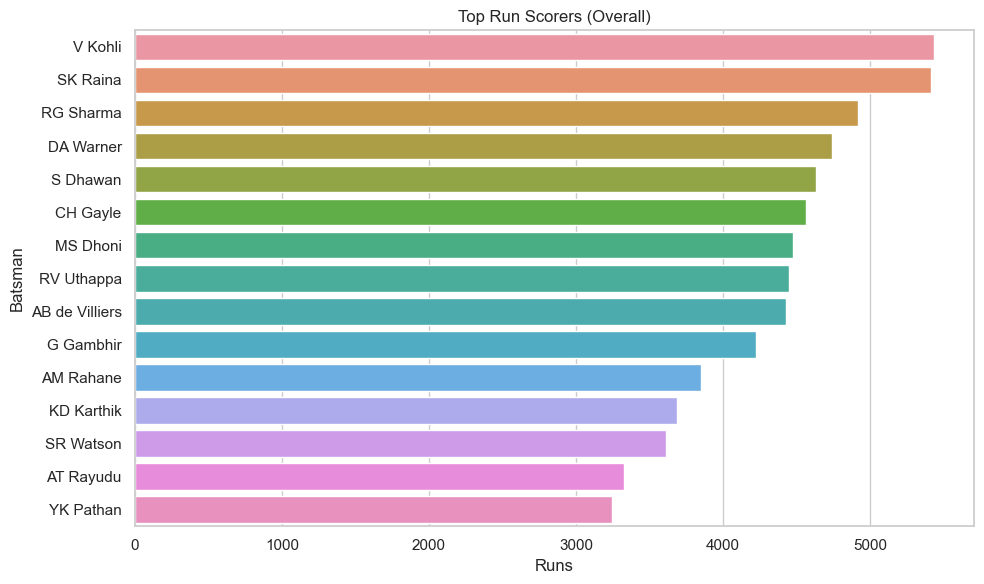

In [16]:
# Plot: Top 15 run scorers overall
plt.figure(figsize=(10,6))
sns.barplot(data=top_batsmen_overall, x="runs", y="batsman")
plt.title("Top Run Scorers (Overall)")
plt.xlabel("Runs")
plt.ylabel("Batsman")
plt.tight_layout()
plt.show()

In [17]:
# Per-season runs → "Orange Cap"-style leaderboard
# Join deliveries to matches to get season per match_id
key = "match_id" if "match_id" in deliveries.columns else "match_id" if "id" not in matches.columns else "match_id"
# Try to detect id columns
match_id_col_matches = "id" if "id" in matches.columns else "match_id"
match_id_col_deliveries = "match_id" if "match_id" in deliveries.columns else "match_id"

deliveries_season = deliveries.merge(
    matches[[match_id_col_matches, "season"]],
    left_on=match_id_col_deliveries, right_on=match_id_col_matches, how="left"
)

season_bat = (deliveries_season
              .groupby(["season","batsman"], as_index=False)["batsman_runs"]
              .sum()
              .rename(columns={"batsman_runs":"runs"}))

orange_cap = (season_bat.sort_values(["season","runs"], ascending=[True, False])
              .groupby("season", as_index=False).first())
orange_cap.rename(columns={"batsman": "top_scorer", "runs": "season_runs"}, inplace=True)
orange_cap.sort_values("season")

,season,top_scorer,season_runs
0,IPL-2008,SE Marsh,616
1,IPL-2009,ML Hayden,572
2,IPL-2010,SR Tendulkar,618
3,IPL-2011,CH Gayle,608
4,IPL-2012,CH Gayle,733
5,IPL-2013,MEK Hussey,733
6,IPL-2014,RV Uthappa,660
7,IPL-2015,DA Warner,562
8,IPL-2016,V Kohli,973
9,IPL-2017,DA Warner,641


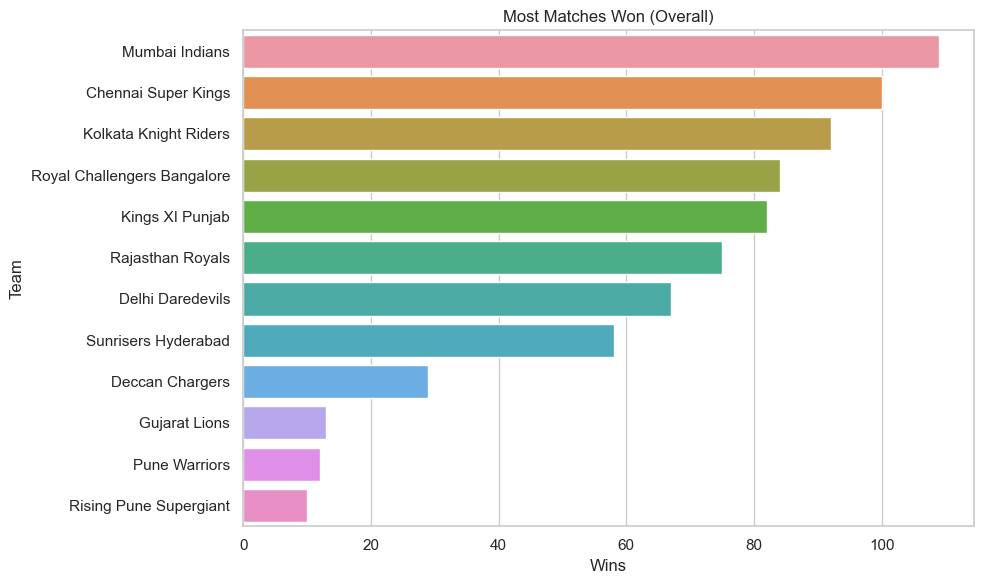

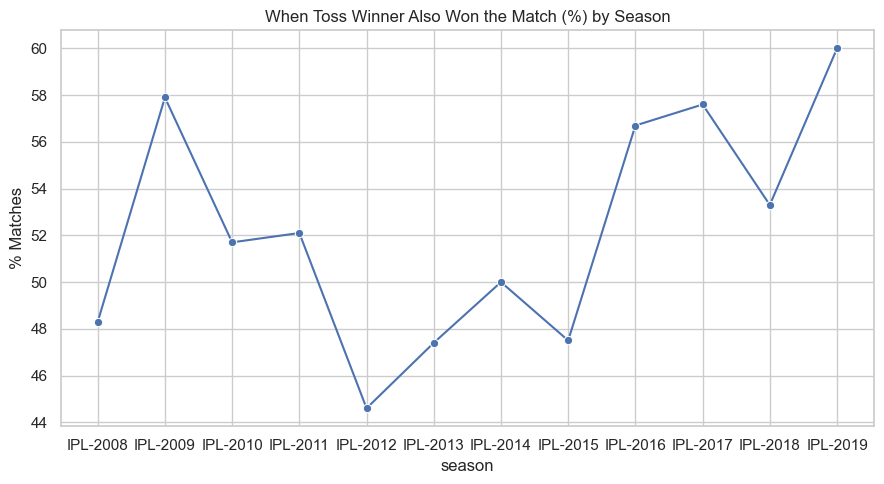

In [18]:
#Team Performance (Wins, Win% per Season, Toss Impact)

# Total wins by team (overall)
team_wins = matches["winner"].value_counts().reset_index()
team_wins.columns = ["team","wins"]
team_wins

plt.figure(figsize=(10,6))
sns.barplot(data=team_wins.head(12), x="wins", y="team")
plt.title("Most Matches Won (Overall)")
plt.xlabel("Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

# Win% per team per season
team_season_games = pd.melt(matches, id_vars=["season"], value_vars=["team1","team2"], var_name="slot", value_name="team")
team_season_games = team_season_games.groupby(["season","team"], as_index=False).size().rename(columns={"size":"played"})

team_season_wins = matches.groupby(["season","winner"], as_index=False).size().rename(columns={"winner":"team","size":"wins"})
team_season = team_season_games.merge(team_season_wins, on=["season","team"], how="left").fillna({"wins":0})
team_season["win_pct"] = (team_season["wins"] / team_season["played"] * 100).round(1)
team_season.sort_values(["season","win_pct"], ascending=[True, False]).head(20)

# Toss winner impact (does winning toss correlate with match win?)
if "toss_winner" in matches.columns:
    toss_df = matches.copy()
    toss_df["toss_win_match_win"] = np.where(toss_df["toss_winner"] == toss_df["winner"], 1, 0)
    toss_impact = toss_df.groupby("season")["toss_win_match_win"].mean().mul(100).round(1).reset_index()
    toss_impact.columns = ["season","%_toss_winner_also_won"]
    toss_impact

    plt.figure(figsize=(9,5))
    sns.lineplot(data=toss_impact, x="season", y="%_toss_winner_also_won", marker="o")
    plt.title("When Toss Winner Also Won the Match (%) by Season")
    plt.ylabel("% Matches")
    plt.tight_layout()
    plt.show()


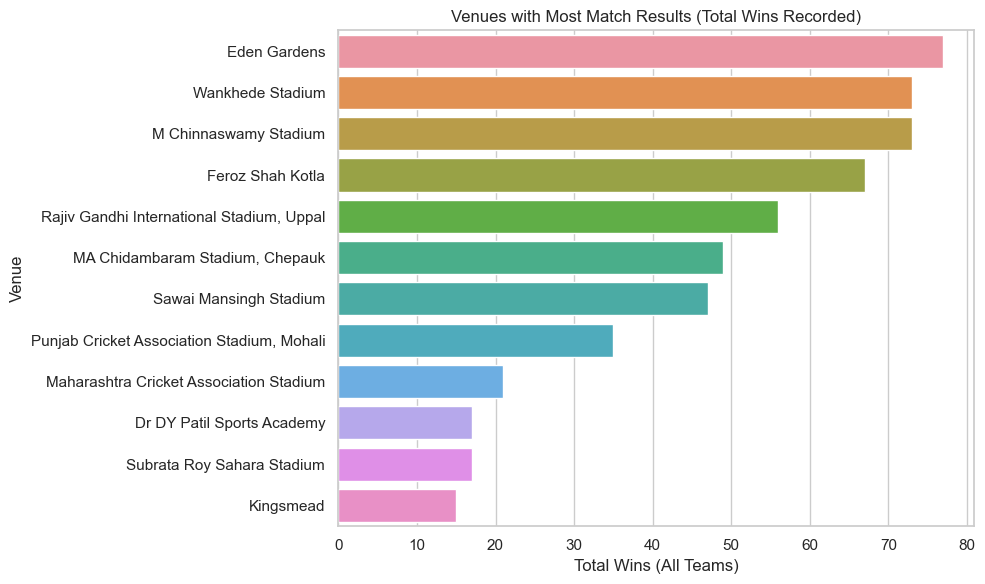

In [19]:
#Venue Trends (Most Wins, Chasing vs Defending)

# Most wins by venue (which venues see the most results for specific teams)
venue_wins = matches.groupby(["venue","winner"], as_index=False).size().rename(columns={"size":"wins"})
top_venues = (venue_wins.groupby("venue")["wins"].sum().sort_values(ascending=False).head(12))
top_venues

plt.figure(figsize=(10,6))
sns.barplot(x=top_venues.values, y=top_venues.index)
plt.title("Venues with Most Match Results (Total Wins Recorded)")
plt.xlabel("Total Wins (All Teams)")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()


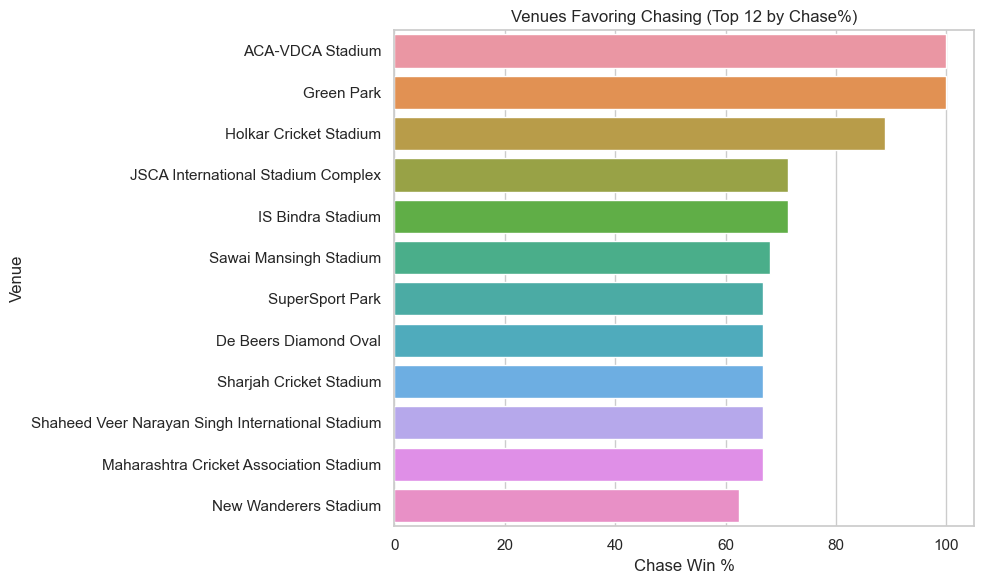

In [20]:
# Chasing vs Defending success by venue (if result info present)
# Many datasets have 'result'/'win_by_runs'/'win_by_wickets' columns
cols = matches.columns
if "win_by_runs" in cols and "win_by_wickets" in cols:
    matches["win_type"] = np.where(matches["win_by_runs"] > 0, "Defended (Runs)",
                            np.where(matches["win_by_wickets"] > 0, "Chased (Wickets)", "Other/NA"))
    venue_chase_defend = (matches.groupby(["venue","win_type"], as_index=False)
                          .size()
                          .pivot(index="venue", columns="win_type", values="size")
                          .fillna(0))
    venue_chase_defend["Chase%"] = (venue_chase_defend.get("Chased (Wickets)", 0) /
                                    venue_chase_defend.sum(axis=1) * 100).round(1)
    venue_chase_defend_sorted = venue_chase_defend.sort_values("Chase%", ascending=False).head(12)
    venue_chase_defend_sorted[["Chase%"]]
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=venue_chase_defend_sorted["Chase%"], y=venue_chase_defend_sorted.index)
    plt.title("Venues Favoring Chasing (Top 12 by Chase%)")
    plt.xlabel("Chase Win %")
    plt.ylabel("Venue")
    plt.tight_layout()
    plt.show()

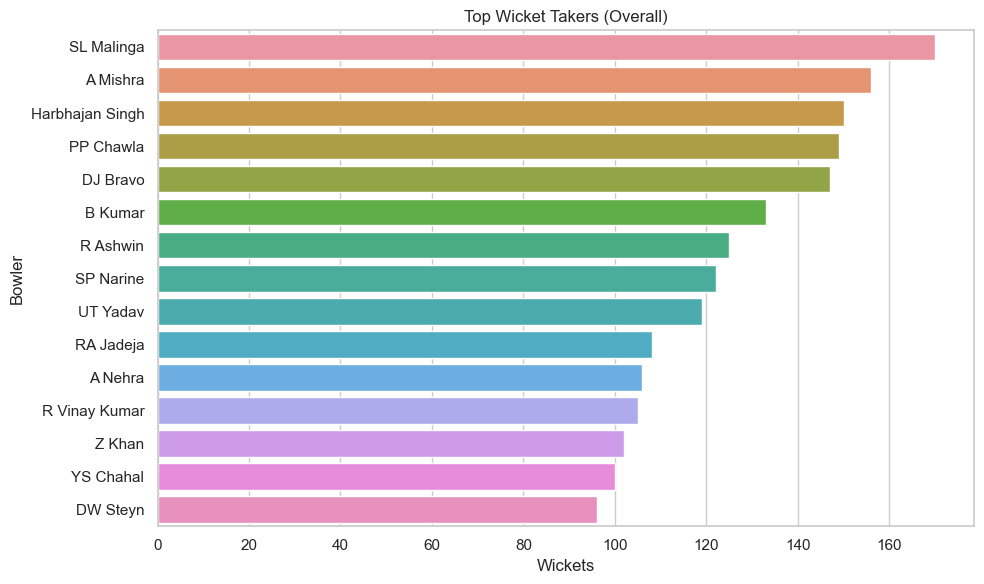

In [21]:
#Bonus: Top Wicket Takers (Overall & by Season)

# Dismissals counting as bowler wickets (exclude run out, retired hurt, obstructing)
wicket_kinds = ["caught", "bowled", "lbw", "caught and bowled", "stumped", "hit wicket"]
is_wicket = deliveries["dismissal_kind"].isin(wicket_kinds)

bowler_wkts = (deliveries.loc[is_wicket]
               .groupby("bowler", as_index=False)
               .size()
               .rename(columns={"size":"wickets"})
               .sort_values("wickets", ascending=False))
bowler_wkts.head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=bowler_wkts.head(15), x="wickets", y="bowler")
plt.title("Top Wicket Takers (Overall)")
plt.xlabel("Wickets")
plt.ylabel("Bowler")
plt.tight_layout()
plt.show()


In [22]:
# Per-season Purple Cap style
bowler_season = (deliveries_season.loc[is_wicket]
                 .groupby(["season","bowler"], as_index=False)
                 .size()
                 .rename(columns={"size":"wickets"}))
purple_cap = (bowler_season.sort_values(["season","wickets"], ascending=[True, False])
              .groupby("season", as_index=False).first()
              .rename(columns={"bowler":"top_bowler","wickets":"season_wkts"}))
purple_cap.sort_values("season")


,season,top_bowler,season_wkts
0,IPL-2008,Sohail Tanvir,22
1,IPL-2009,RP Singh,23
2,IPL-2010,PP Ojha,21
3,IPL-2011,SL Malinga,28
4,IPL-2012,M Morkel,25
5,IPL-2013,DJ Bravo,32
6,IPL-2014,MM Sharma,23
7,IPL-2015,DJ Bravo,26
8,IPL-2016,B Kumar,23
9,IPL-2017,B Kumar,26


In [23]:
#Quick Text Summary (auto-filled from your data)

summary = {}

# Top batsman
if not runs_by_batsman.empty:
    summary["Top run-scorer (overall)"] = f"{runs_by_batsman.iloc[0]['batsman']} — {runs_by_batsman.iloc[0]['runs']} runs"

# Top bowler
if not bowler_wkts.empty:
    summary["Top wicket-taker (overall)"] = f"{bowler_wkts.iloc[0]['bowler']} — {bowler_wkts.iloc[0]['wickets']} wickets"

# Team with most wins
if not team_wins.empty:
    summary["Most wins (team)"] = f"{team_wins.iloc[0]['team']} — {int(team_wins.iloc[0]['wins'])} wins"

# Toss impact latest season snapshot
if "toss_winner" in matches.columns:
    latest_season = matches["season"].max()
    tmp = matches[matches["season"]==latest_season].copy()
    tmp["toss_win_match_win"] = (tmp["toss_winner"]==tmp["winner"]).astype(int)
    summary["Latest season: Toss-winner also won (%)"] = round(tmp["toss_win_match_win"].mean()*100,1)

summary


{'Top run-scorer (overall)': 'V Kohli — 5434 runs',
 'Top wicket-taker (overall)': 'SL Malinga — 170 wickets',
 'Most wins (team)': 'Mumbai Indians — 109 wins',
 'Latest season: Toss-winner also won (%)': 60.0}

In [24]:
orange_cap.to_csv("ipl_top_scorers_by_season.csv", index=False)
purple_cap.to_csv("ipl_top_wicket_takers_by_season.csv", index=False)
team_season.to_csv("ipl_team_winpct_by_season.csv", index=False)
venue_wins.to_csv("ipl_venue_team_wins.csv", index=False)
"Saved summary tables."


'Saved summary tables.'